In [1]:
import sys
sys.path.append('..')
import nest
import nest.raster_plot
import numpy as np
from sklearn.decomposition import PCA

from utils.inputs import generate_piecewise_constant_signal
from utils.capacity import compute_capacity
from stdp.utils.cv import (
    group_spike_times_by_neuron,
    calculate_cv,
    collect_cvs,
    plot_cv_distribution)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:38:39

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



# Global settings

In [2]:
seed = 1
np.random.seed(seed)

In [3]:
dt = 0.1  # simulation resolution
sim_time = 1000. # simulation time [ms] (for each epoch)

num_threads = 8

# Initialize NEST
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})


Oct 23 17:49:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


---
# Balanced Random Network

For this example, we will use a standard Brunel balanced random network (see NEST tutorials). However, you are encouraged to explore different neuron and synapse models.

In [4]:
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons, number of excitatory synapses per neuron
CI = int(gamma * CE)       # indegree from inhibitory neurons, number of inhibitory synapses per neuron

In [5]:
# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)
g = 5.                     # relative inhibitory to excitatory synaptic weight ???
d = 1.5                    # synaptic transmission delay (ms)

In [6]:
# neuron paramters
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}

### Create and connect populations

In [7]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# create excitatory connections
# E synapses
#Heterogenity
alpha_min = 0.1
alpha_max = 1
#Barna Style
delay =1.5;
nest.CopyModel(
    # "stdp_pl_synapse_nestml",
    "stdp_pl_synapse_hom",
    "excitatory_plastic",
    {
        #"alpha": nest.random.uniform(min=alpha_min, max=alpha_max), #heterogenity
        "alpha": 0.1,  # magnitude of weight update for causal firing
        "lambda": 20.0,  # magnitude of weight update for causal firing
        "mu": 0.4,  # weight dependence exponent for causal firing
        "tau_plus": 15.0,  # time constant of weight update for causal firing (ms)
        #"tau_minus": 30.0,  # time constant of weight update for acausal firing (ms)
        # "weight": 1.0,
        "weight": w,
        "delay": delay,
    },
)
syn_dict = {"synapse_model": "excitatory_plastic"}
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_dict)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# create inhibitory connections
# synapse specification
syn_inh = {'delay': d, 'weight': - g * w}
# connection specification
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
# connect stuff
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)




### Create and connect external inputs
We are going to drive the circuit with noise for an initial period, followed by a patterned stimulus signal.

In [8]:
# external input parameters (background noise)
nu_th = V_th / (w * CE * tau_m) # external rate needed to evoke activity (spikes/ms)
nu_ex = 2.0 * nu_th             # set external rate above threshold ????
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)

In [9]:
print(
    w, 
    nu_ex,
    nu_th,
    p_rate
)

0.316227766016838 0.06324555320336757 0.031622776601683784 6324.555320336757


In [10]:
# external input (stimulus)
# input_dt = 1.          # [ms] 
step_duration = 50.    # [ms]
scale = p_rate / 2.    # scale input amplitude (max. rate)
# num_steps = 100        # number of unique input values


sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(seed=seed, num_steps=int(sim_time/step_duration), step_duration=step_duration, resolution=dt, scale=scale)
inp_times += sim_time  # stimulus starts after the noise phase

#######
# # Ensure inp_times are in the future
# kernel_status = nest.GetKernelStatus()
# print(kernel_status.keys())  # Print available keys to identify the correct one
# current_time = kernel_status['biological_time']  # Adjust this line if 'time' is not the correct key
# inp_times = np.array(inp_times)
# if np.any(inp_times <= current_time):
#     inp_times = inp_times + (current_time - np.min(inp_times)) + 1  # Shift all times to be in the future


Text(0.5, 1.0, '$u(t)$')

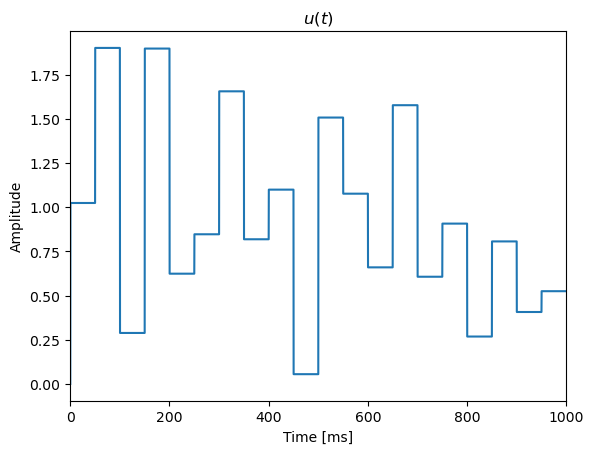

In [11]:
# visualize example input stimulus
fig, ax = plt.subplots()
ax.plot(times, sig)
ax.set_xlim([0, 1000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')

In [12]:
# create poisson generator (noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': sim_time})

# create inhomogeneous poisson generator (time-dependent input signal)
stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
nest.SetStatus(stim_pgen, params={'rate_times': inp_times, 'rate_values': inp_amplitudes})



In [13]:
# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)



### Create and connect recording devices
Since we are going to compare the population responses to stimulus versus noise, the simplest way is to record them separately. 

In [14]:
spikes_E_noise = nest.Create('spike_recorder')
spikes_I_noise = nest.Create('spike_recorder')
spikes_E_stim  = nest.Create('spike_recorder')
spikes_I_stim  = nest.Create('spike_recorder')
vm = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': dt})


In [15]:
# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_noise)
nest.Connect(neurons_e, spikes_E_stim)
nest.Connect(neurons_i, spikes_I_noise)
nest.Connect(neurons_i, spikes_I_stim)

nest.Connect(vm, neurons_e)

## Simulate and analyse

In [16]:
# simulate (noise-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_noise, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_noise, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))


Oct 23 17:49:44 NodeManager::prepare_nodes [Info]: Mean firing rate: 29.268 Hz (E: 18.868 Hz, I: 39.668 Hz)

    Preparing 1306 nodes for simulation.

Oct 23 17:49:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1306
    Simulation time (ms): 1000
    Number of OpenMP threads: 8
    Not using MPI

[ 100% ] Model time: 997.0 ms, Real-time factor: 0.1467.0 ms, Real-time factor: 0.1154

[ 100% ] Model time: 1000.0 ms, Real-time factor: 0.1466

Oct 23 17:49:44 SimulationManager::run [Info]: 
    Simulation finished.


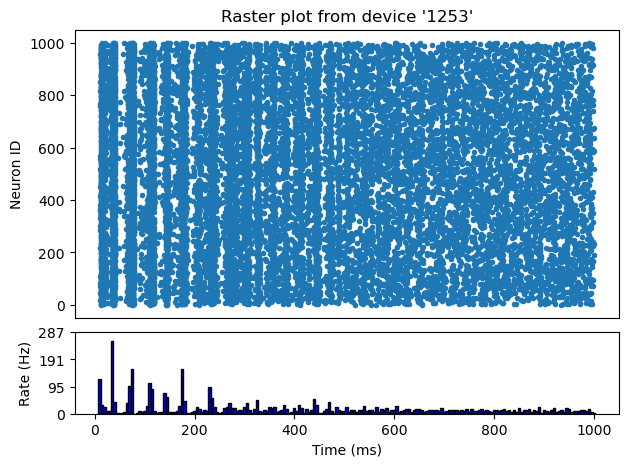

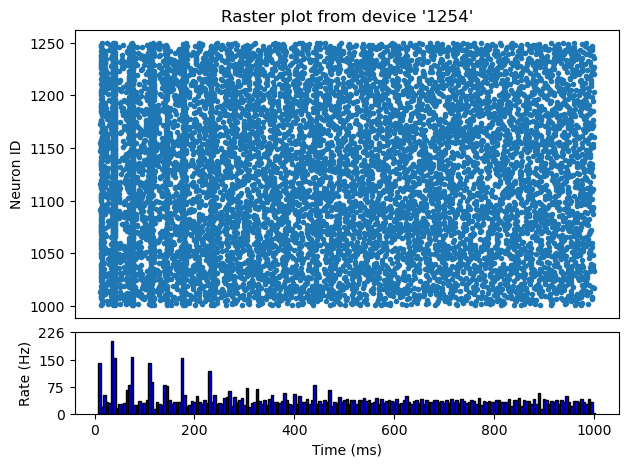

In [17]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_noise, hist=True)
nest.raster_plot.from_device(spikes_I_noise, hist=True)

In [18]:
# simulate (stimulus-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_stim, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_stim, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))


Oct 23 17:49:44 NodeManager::prepare_nodes [Info]: 
    Preparing 1306Mean firing rate: 35.0085 Hz (E: 21.873 Hz, I: 48.144 Hz)
 nodes for simulation.

Oct 23 17:49:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1306
    Simulation time (ms): 1000
    Number of OpenMP threads: 8
    Not using MPI

[  49% ] Model time: 1487.0 ms, Real-time factor: 0.114154.0 ms, Real-time factor: 0.1166

[  74% ] Model time: 1732.0 ms, Real-time factor: 0.1374

[ 100% ] Model time: 2000.0 ms, Real-time factor: 0.1245

Oct 23 17:49:45 SimulationManager::run [Info]: 
    Simulation finished.


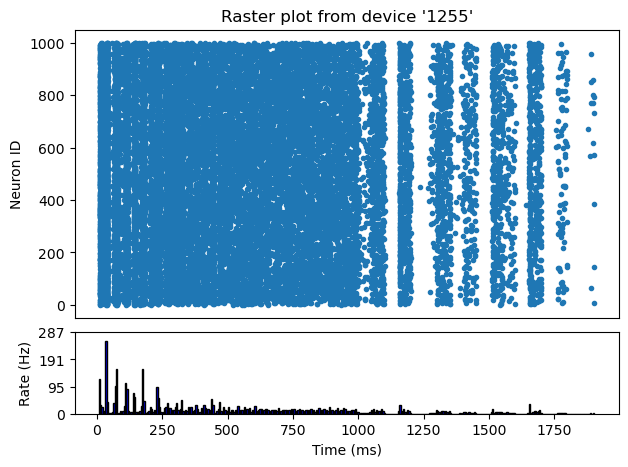

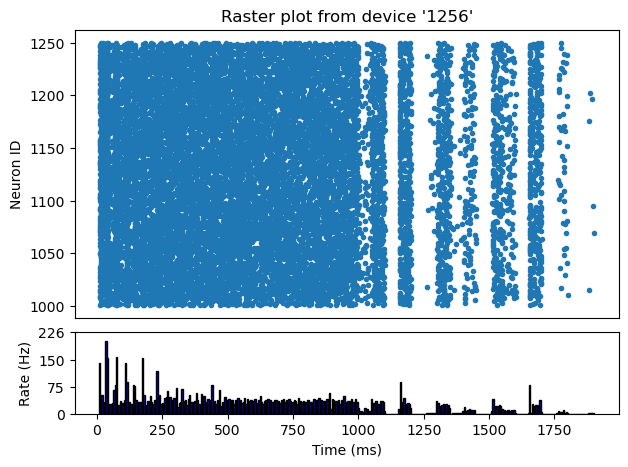

In [19]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_stim, hist=True)
nest.raster_plot.from_device(spikes_I_stim, hist=True)

To explore:

* Characterize the population activity statistics in the two regimes, evaluating the distribution of rates, regularity ($CV_{ISI}$) and synchrony (pairwise correlation coefficient) 
* Change the stimulation parameters to reach a *healthier* dynamic regime in the input-driven condition
* Test different neuron and synapse models

# Post- process data

In [20]:
num_steps=int(sim_time/step_duration)
activity = vm.events
indices = np.sort(np.unique(activity['senders']))
states = np.zeros((NE, int(num_steps*step_duration)))
# for idx, i in enumerate(indices):
#     states[idx, :] = activity['V_m'][np.where(activity['senders']==i)[0]]

for idx, i in enumerate(indices):
    vm_values = activity['V_m'][np.where(activity['senders'] == i)[0]]
    if vm_values.shape[0] > states.shape[1]:
        vm_values = vm_values[:states.shape[1]]  # Truncate if larger
    elif vm_values.shape[0] < states.shape[1]:
        vm_values = np.pad(vm_values, (0, states.shape[1] - vm_values.shape[0]), 'constant')  # Pad if smaller
    states[idx, :] = vm_values

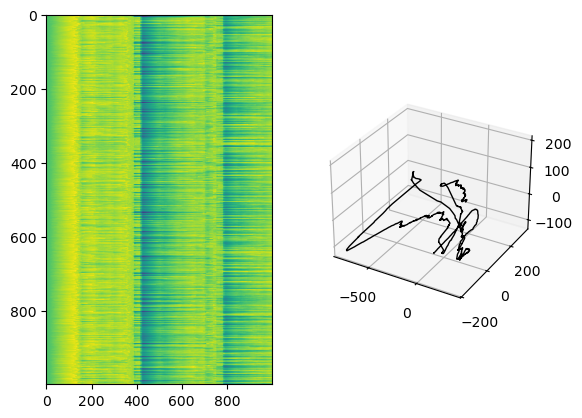

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(states, aspect='auto')
ax2 = fig.add_subplot(122, projection='3d')
pca_fit = PCA(n_components=np.shape(states)[0])
X = pca_fit.fit_transform(states.T)
ax2.plot(X[:, 0], X[:, 1], X[:, 2], color='k', lw=1)

# Decoding

In [22]:
# exclude initial values at time 0.
sig = sig[1:]
times = times[1:]

In [23]:
# Ensure states and sig have the same number of samples
num_samples = min(states.shape[1], sig.shape[0])
states = states[:, :num_samples]
sig = sig[:num_samples]

# computes memory capacity at stimulus offset
estimate, capacity, error = compute_capacity(states, sig)
print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))


Elapsed time for capacity computation: 0.3039369583129883
Capacity=0.9288601190599655, MSE=0.016776780901850717


# Memory capacity

In [24]:
max_lag = 100.   # [ms] in this example
step_lag = 10.   # [ms] evaluate in discrete time points (alternatively set == 1. for higher resolution)
time_lags = np.arange(dt, max_lag, step_lag)
indices = [np.where(idx == times)[0][0] if np.where(idx == times)[0].size > 0 else None for idx in time_lags]

memory_capacity = []

for idx, lag in zip(indices, time_lags):
    if idx is None:
        continue  # Skip if index is None
    # shift the target signal
    if idx > 0:
        shifted_signal = sig[:-idx]
    else:
        shifted_signal = sig
    
    # shift the population states
    st = states[:, idx:]
    
    # compute capacity
    estimate, capacity, error = compute_capacity(st, shifted_signal)
    
    print("Lag = {0} ms".format(str(lag)))
    print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))
    
    memory_capacity.append(capacity)
    
    


Elapsed time for capacity computation: 0.3522517681121826
Lag = 0.1 ms
Capacity=0.9288601190599655, MSE=0.016776780901850717

Elapsed time for capacity computation: 0.27207517623901367
Lag = 20.1 ms
Capacity=1.0025046953247272, MSE=2.0908178973155646e-28

Elapsed time for capacity computation: 0.2689340114593506
Lag = 30.1 ms
Capacity=1.0028632769887904, MSE=6.838029454880157e-29

Elapsed time for capacity computation: 0.342418909072876
Lag = 40.1 ms
Capacity=1.0033416852238426, MSE=3.14671684712004e-29

Elapsed time for capacity computation: 0.2465810775756836
Lag = 50.1 ms
Capacity=1.1524406403108039e-05, MSE=6.392238522619012e-30

Elapsed time for capacity computation: 0.17074084281921387
Lag = 60.1 ms
Capacity=0.0002802965390227177, MSE=4.465692280649572e-30


In [25]:
print(len(time_lags))
print(len(memory_capacity))
    

10
6


Total capacity: 39.378615975427515 ms


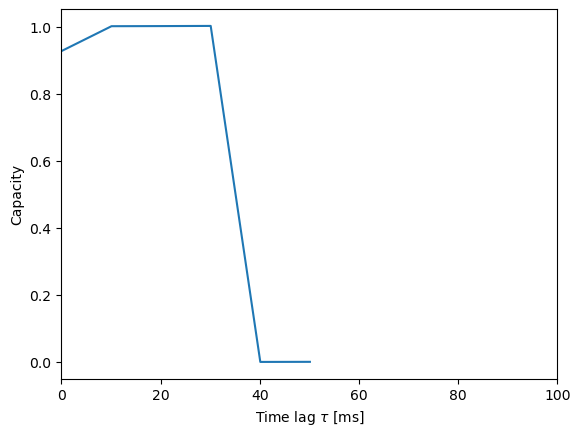

In [26]:
# Ensure time_lags and memory_capacity have the same length
min_length = min(len(time_lags), len(memory_capacity))
time_lags = time_lags[:min_length]
memory_capacity = memory_capacity[:min_length]

fig, ax = plt.subplots()
ax.plot(time_lags, memory_capacity)
ax.set_xlim([0., max_lag])
ax.set_xlabel(r'Time lag $\tau$ [ms]')
ax.set_ylabel(r'Capacity')
print("Total capacity: {0} ms".format(str(np.sum(memory_capacity)*step_lag)))

# CV

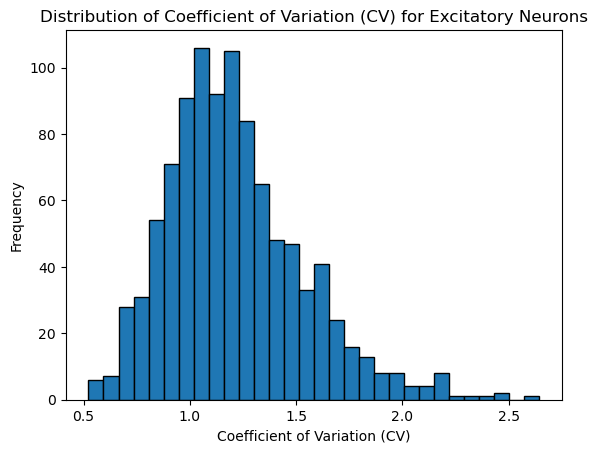

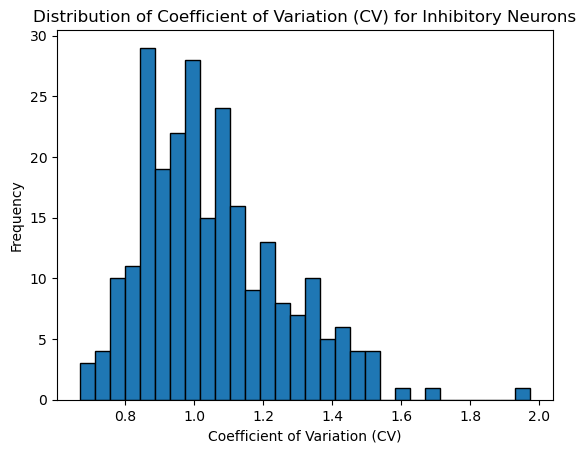

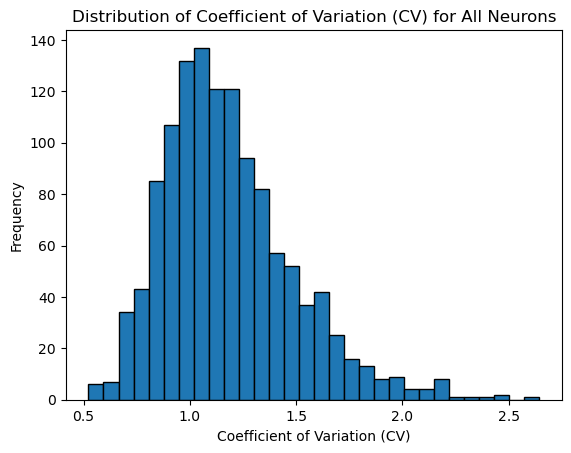

In [28]:
spikes_E_stim = nest.GetStatus(spikes_E_stim, keys='events')[0]
spikes_I_stim = nest.GetStatus(spikes_I_stim, keys='events')[0]

spike_times_E = group_spike_times_by_neuron(spikes_E_stim)
spike_times_I = group_spike_times_by_neuron(spikes_I_stim)

# Convert the spike times dictionary to a list of lists
neurons_spike_times_E = list(spike_times_E.values())
neurons_spike_times_I = list(spike_times_I.values())

# Collect CVs for excitatory and inhibitory neurons separately
cvs_E = collect_cvs(neurons_spike_times_E)
cvs_I = collect_cvs(neurons_spike_times_I)


# Plot the distribution of CVs for excitatory neurons
plot_cv_distribution(cvs_E, 'Distribution of Coefficient of Variation (CV) for Excitatory Neurons')

# Plot the distribution of CVs for inhibitory neurons
plot_cv_distribution(cvs_I, 'Distribution of Coefficient of Variation (CV) for Inhibitory Neurons')

# Combine CVs and plot the distribution for both
cvs_combined = cvs_E + cvs_I
plot_cv_distribution(cvs_combined, 'Distribution of Coefficient of Variation (CV) for All Neurons')